In [1]:
import pandas as pd
import utils
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
import itertools

In [2]:
batch = "2020_11_04_CPJUMP1"
pert_iname = ["BI-2536", "PFI-1", "TG-101348"]
pert_iname_combinations = list(itertools.combinations(pert_iname, 2))

experiment_df = (
    pd.read_csv("output/experiment-metadata.tsv", sep="\t")
    .query("Batch==@batch")
    .query("Density==100")
    .query('Antibiotics=="absent"')
    .query('Perturbation=="compound"')
)

experiment_df.drop(
    experiment_df[
        (experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")
    ].index,
    inplace=True,
)

In [3]:
perturbation_cosine_sim_df = pd.DataFrame()

for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query("Cell_type==@cell")
    for timepoint in cell_df.Time.unique():
        timepoint_df = cell_df.query("Time==@timepoint")
        df = pd.DataFrame()
        for plate in timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = utils.load_data(
                batch, plate, "normalized_feature_select_negcon_batch.csv.gz"
            )
            df = utils.concat_profiles(df, data_df)
        df = df.query("Metadata_pert_iname in @pert_iname")
        consensus_df = utils.consensus(df, "Metadata_pert_iname")

        features_df = utils.get_featuredata(consensus_df)
        cosine_sim = cosine_similarity(features_df.values)
        cosine_sim_df = pd.DataFrame(
            cosine_sim,
            index=list(consensus_df.Metadata_pert_iname),
            columns=list(consensus_df.Metadata_pert_iname),
        )
        for _ in pert_iname_combinations:
            perturbation_cosine_sim_df = pd.concat(
                [
                    perturbation_cosine_sim_df,
                    pd.DataFrame(
                        {
                            "Cell": cell,
                            "Time": timepoint,
                            "Perturbations": f"{_[0]}_{_[1]}",
                            "Cosine_Similarity": cosine_sim_df.loc[_[0], _[1]],
                        },
                        index=[0],
                    ),
                ],
                ignore_index=True,
            )
            

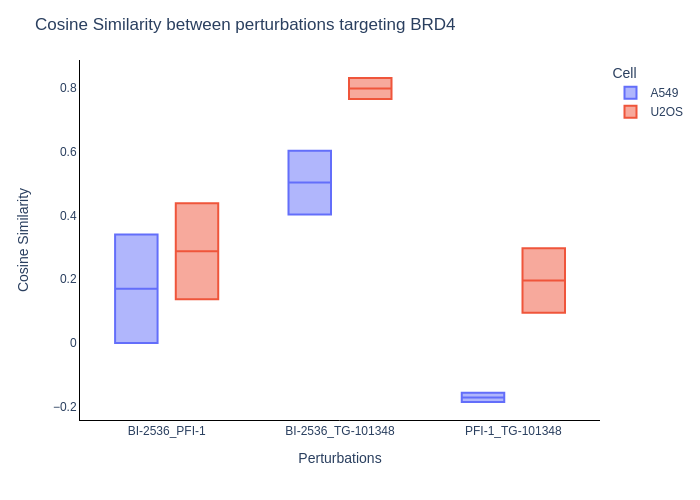

In [4]:
fig = px.box(
    perturbation_cosine_sim_df,
    x="Perturbations",
    y="Cosine_Similarity",
    color="Cell",
)

fig.update_layout(
    title="Cosine Similarity between perturbations targeting BRD4",
    xaxis=dict(title="Perturbations", linecolor="#000000"),
    yaxis=dict(title="Cosine Similarity", linecolor="#000000"),
    plot_bgcolor="rgba(0,0,0,0)",
)

fig.show("png")
fig.write_image(
    "figures/BRD4_compounds_cosine_similarities.png", width=640, height=480, scale=2
)